# PREP

In [162]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
    load_image,
)
from wildlifeml.data import subset_dataset
from wildlifeml.utils.datasets import render_bbox, map_bbox_to_img, separate_empties
from wildlifeml.preprocessing.cropping import Cropper

In [138]:
REPODIR = '/home/wimmerl/projects/wildlife-experiments'
IMGDIR = '/common/bothmannl/wildlife_images/usecase2/original_images/'
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))

In [139]:
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
LABEL_DICT = {k: v for k, v in load_csv(os.path.join(CFG['data_dir'], CFG['label_file']))}
MAPPING_DICT = load_json(os.path.join(CFG['data_dir'], CFG['mapping_file']))
DETECTOR_DICT = load_json(os.path.join(CFG['data_dir'], CFG['detector_file']))
META_DF = pd.read_csv(os.path.join(CFG['data_dir'], 'metadata.csv'))

# DESCRIPTIVE

## STATS

In [143]:
META_DF.groupby(['station_set'])['orig_name'].count()

station_set
s1    24368
s2    23748
Name: orig_name, dtype: int64

In [140]:
cnt_ins_oos = META_DF.groupby(['station_set', 'true_class'])['orig_name'].count()
cnt_ins_oos, cnt_ins_oos.groupby(['true_class']).sum()  # Table 1

(station_set  true_class   
 s1           empty            15627
              european_hare      485
              others             941
              red_deer            26
              red_fox            708
              red_squirrel       297
              roe_deer          6074
              wild_boar          210
 s2           empty            14274
              european_hare      255
              others            1051
              red_deer           135
              red_fox            106
              red_squirrel        13
              roe_deer          7010
              wild_boar          904
 Name: orig_name, dtype: int64,
 true_class
 empty            29901
 european_hare      740
 others            1992
 red_deer           161
 red_fox            814
 red_squirrel       310
 roe_deer         13084
 wild_boar         1114
 Name: orig_name, dtype: int64)

In [164]:
dataset_oos_trainval = load_pickle(os.path.join(REPODIR, 'data', 'dataset_oos_trainval.pkl'))
_, keys_all_nonempty = separate_empties(os.path.join(CFG['data_dir'], CFG['detector_file']), float(0.5))
keys_oos_trainval = list(set(dataset_oos_trainval.keys).intersection(set(keys_all_nonempty)))
dataset_oos_trainval = subset_dataset(dataset_oos_trainval, keys_oos_trainval)
len(set(map_bbox_to_img(dataset_oos_trainval.keys)))

10020

## EXEMPLARY MISCLASSIFIED CASES

In [165]:
results = load_pickle('results/passive/50/202303160957_insample_test_123.pkl')
OUR_THRESH = 0.5

In [166]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# TODO speichern regeln, coord sys, img name weg !!!!

In [184]:
def inspect_images(
    results, 
    true_label: str, 
    label_map: dict, 
    mapping_dict: dict,
    detector_dict: dict,
    n_displays: int, 
    img_dir: str,
    is_misclassified: bool,
    sorting: str,  # ['asc', 'desc', 'rand'],
    min_conf: float = 0.,
    max_conf: float = 1.
):
    preds_imgs_ppl, truth_imgs_ppl = sort_results(results['preds_imgs_ppl'], results['truth_imgs_ppl'])
    result_ranking = pd.DataFrame(
        zip(
            sorted(list(results['preds_imgs_ppl'].keys())), 
            [np.argmax(v) for v in preds_imgs_ppl],
            [np.max(v) for v in preds_imgs_ppl],
            truth_imgs_ppl,
        ),
        columns=['img', 'pred_label', 'conf', 'true_label']
    )
    result_ranking = result_ranking.loc[result_ranking['true_label'] == label_map[true_label]]
    if is_misclassified:
        result_ranking = result_ranking.loc[result_ranking['pred_label'] != label_map[true_label]]

    if sorting == 'asc':
        img_keys = result_ranking.sort_values('conf')['img'][:n_displays]
    elif sorting == 'desc':
        img_keys = result_ranking.sort_values('conf', ascending=False)['img'][:n_displays]
    else: 
        img_keys = random.sample(list(result_ranking['img']), n_displays)

    result_dict = {}
    for idx, k in enumerate(img_keys):
        pred_class = np.argmax(preds_imgs_ppl[idx, ...])
        bbox_keys = mapping_dict[k]
        fig, ax = plt.subplots()
        ax.set_yticks([])
        ax.set_xticks([])
        img = load_image(os.path.join(img_dir, k))
        width, height = img.size
        x_coords, y_coords = [], []
        for bkey in bbox_keys:
            bbox = detector_dict[bkey].get('bbox')
            if bbox is not None:
                x, y = Cropper.get_absolute_coords(detector_dict[bkey].get('bbox'), (height, width))
                x_coords.append(x)
                y_coords.append(y)
        img = render_bbox(img, x_coords, y_coords)
        ax.imshow(img)
        plt.show()
        plt.close()
        pred_class = result_ranking.loc[result_ranking['img'] == k, 'pred_label'].values[0]
        pred_class_name = [k for k, v in label_map.items() if v == pred_class][0]
        conf = result_ranking.loc[result_ranking['img'] == k]['conf'].item()
        result_dict.update({k: img})
        print(
            f'Image: {k}\nTrue: {true_label}\nPredicted: {pred_class_name}\nConfidence: {conf:.2f}'
        )
    return result_dict

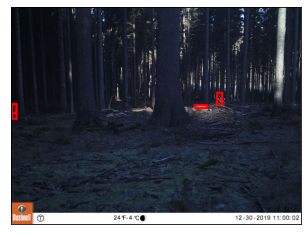

Image: 7254_12300188.JPG
True: empty
Predicted: roe_deer
Confidence: 0.77


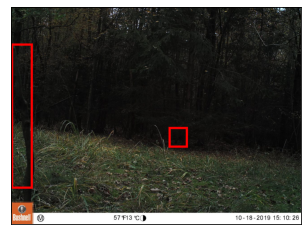

Image: 49404_10180570.JPG
True: empty
Predicted: others
Confidence: 0.99


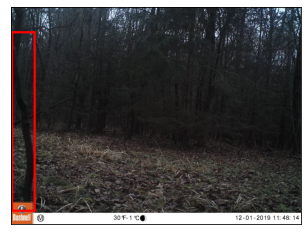

Image: 49596_12010440.JPG
True: empty
Predicted: others
Confidence: 0.82


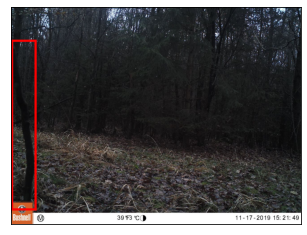

Image: 49377_11170209.JPG
True: empty
Predicted: others
Confidence: 0.74


Image: 48549_02120007.JPG
True: empty
Predicted: others
Confidence: 0.89


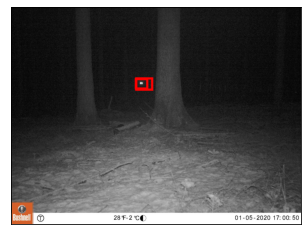

Image: 5452_01050817.JPG
True: empty
Predicted: others
Confidence: 0.66


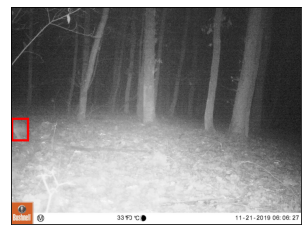

Image: 18127_11210457.JPG
True: empty
Predicted: others
Confidence: 0.66


Image: 50534_11160156.JPG
True: empty
Predicted: others
Confidence: 0.91


Image: 49977_11080969.JPG
True: empty
Predicted: others
Confidence: 0.97


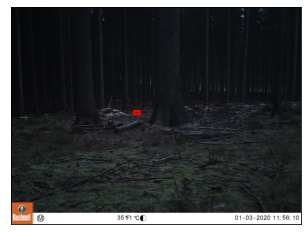

Image: 4405_01030621.JPG
True: empty
Predicted: roe_deer
Confidence: 0.81


Image: 47992_10180567.JPG
True: empty
Predicted: others
Confidence: 0.99


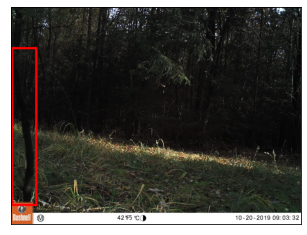

Image: 49889_10200599.JPG
True: empty
Predicted: others
Confidence: 0.99


Image: 55454_01300068.JPG
True: empty
Predicted: others
Confidence: 0.98


Image: 3468_01030472.JPG
True: empty
Predicted: roe_deer
Confidence: 1.00


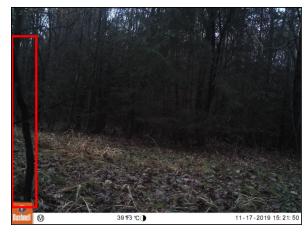

Image: 49869_11170210.JPG
True: empty
Predicted: others
Confidence: 0.87


Image: 7251_12170667.JPG
True: empty
Predicted: roe_deer
Confidence: 0.60


Image: 5497_12100348.JPG
True: empty
Predicted: roe_deer
Confidence: 0.94


Image: 47232_12150780.JPG
True: empty
Predicted: roe_deer
Confidence: 0.89


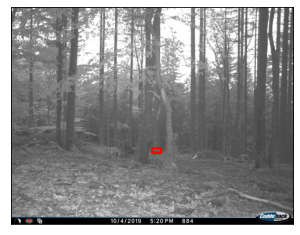

Image: 3001_I_00007b.JPG
True: empty
Predicted: roe_deer
Confidence: 0.95


Image: 50044_02040815.JPG
True: empty
Predicted: others
Confidence: 0.64


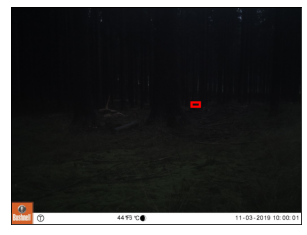

Image: 3796_11030853.JPG
True: empty
Predicted: others
Confidence: 0.39


Image: 50068_11160200.JPG
True: empty
Predicted: others
Confidence: 0.94


Image: 48471_02160074.JPG
True: empty
Predicted: others
Confidence: 0.90


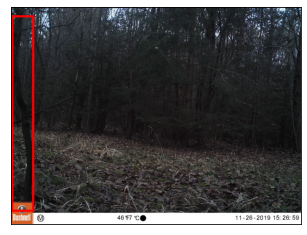

Image: 46755_11260357.JPG
True: empty
Predicted: others
Confidence: 0.76


Image: 50486_10170509.JPG
True: empty
Predicted: others
Confidence: 0.99


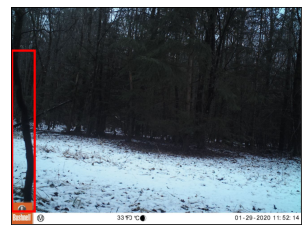

Image: 47884_01290669.JPG
True: empty
Predicted: others
Confidence: 0.82


Image: 47381_11100034.JPG
True: empty
Predicted: others
Confidence: 0.93


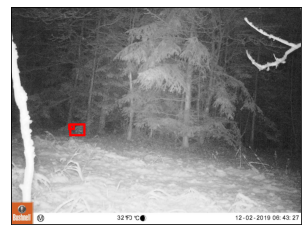

Image: 50513_12020494.JPG
True: empty
Predicted: others
Confidence: 0.48


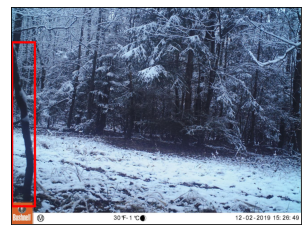

Image: 47686_12020506.JPG
True: empty
Predicted: roe_deer
Confidence: 0.46


Image: 4830_11280861.JPG
True: empty
Predicted: roe_deer
Confidence: 0.81


Image: 47217_10180566.JPG
True: empty
Predicted: others
Confidence: 0.99


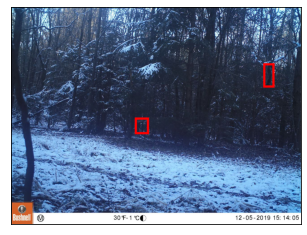

Image: 46639_12050552.JPG
True: empty
Predicted: others
Confidence: 0.59


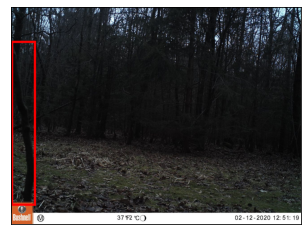

Image: 49925_02120002.JPG
True: empty
Predicted: others
Confidence: 0.85


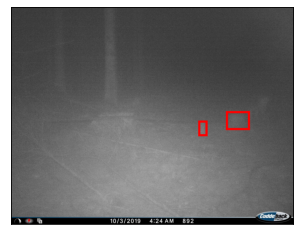

Image: 11121_I_00028b.JPG
True: empty
Predicted: roe_deer
Confidence: 0.59


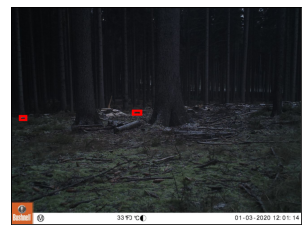

Image: 6870_01030649.JPG
True: empty
Predicted: roe_deer
Confidence: 0.80


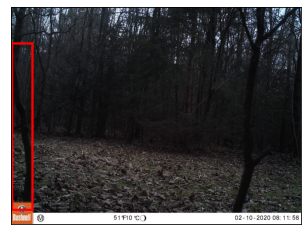

Image: 47175_02100967.JPG
True: empty
Predicted: others
Confidence: 0.92


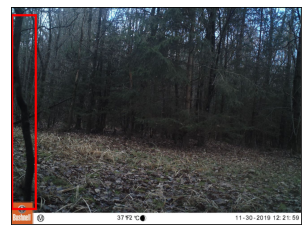

Image: 46730_11300423.JPG
True: empty
Predicted: others
Confidence: 0.90


Image: 48808_02120003.JPG
True: empty
Predicted: others
Confidence: 0.85


Image: 5392_10300713.JPG
True: empty
Predicted: roe_deer
Confidence: 0.89


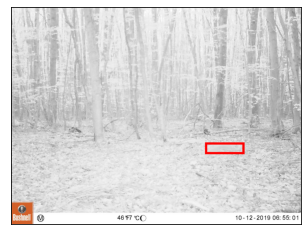

Image: 8234_10120079.JPG
True: empty
Predicted: red_fox
Confidence: 0.53


In [188]:
random.seed(456)
true_empty = inspect_images(
    results=results, 
    true_label='empty',
    label_map=LABEL_MAP,
    mapping_dict=MAPPING_DICT,
    detector_dict=DETECTOR_DICT,
    n_displays=40,
    img_dir=IMGDIR,
    is_misclassified=True,
    sorting='rand'
)

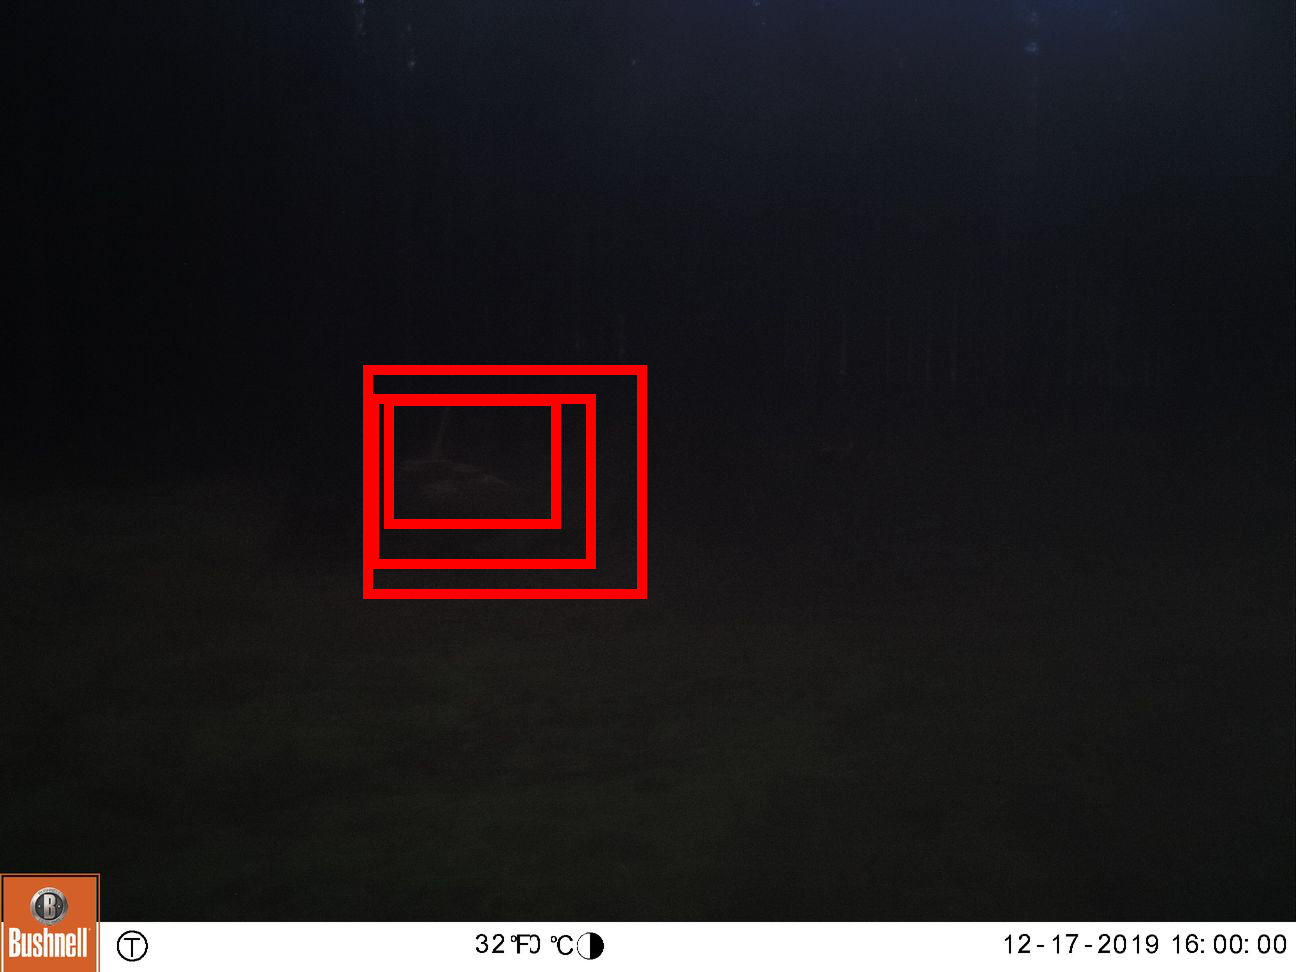

In [189]:
true_empty['7251_12170667.JPG']
plt.savefig('figures/active_learning.png')

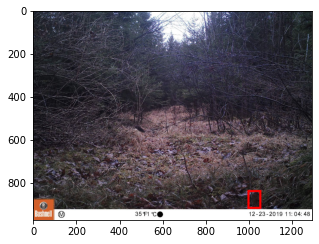

Image: 125626_12230487.JPG
True: red_squirrel
Predicted: empty
Confidence: 1.00


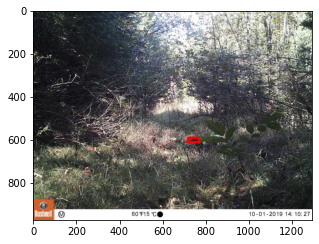

Image: 58176_10010192.JPG
True: red_squirrel
Predicted: empty
Confidence: 1.00


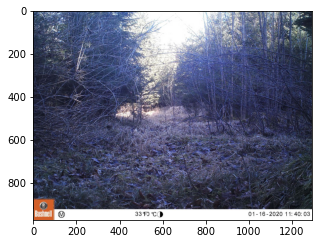

Image: 56216_01160755.JPG
True: red_squirrel
Predicted: empty
Confidence: 1.00


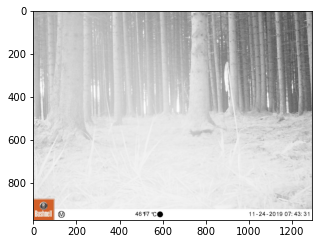

Image: 109042_11240593.JPG
True: red_squirrel
Predicted: empty
Confidence: 1.00


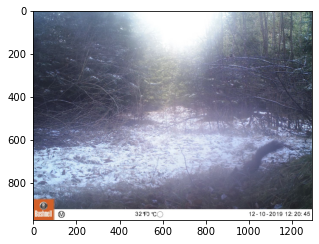

Image: 57923_12100622.JPG
True: red_squirrel
Predicted: empty
Confidence: 1.00


In [59]:
inspect_images(
    results=results, 
    label='red_squirrel',
    label_map=LABEL_MAP,
    mapping_dict=MAPPING_DICT,
    detector_dict=DETECTOR_DICT,
    n_displays=5,
    img_dir=IMGDIR,
    is_misclassified=True,
    sorting='rand',
#     min_conf=0.8,
)